In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib
from scipy import stats
from scipy.optimize import minimize
import json

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
# fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-000-3-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


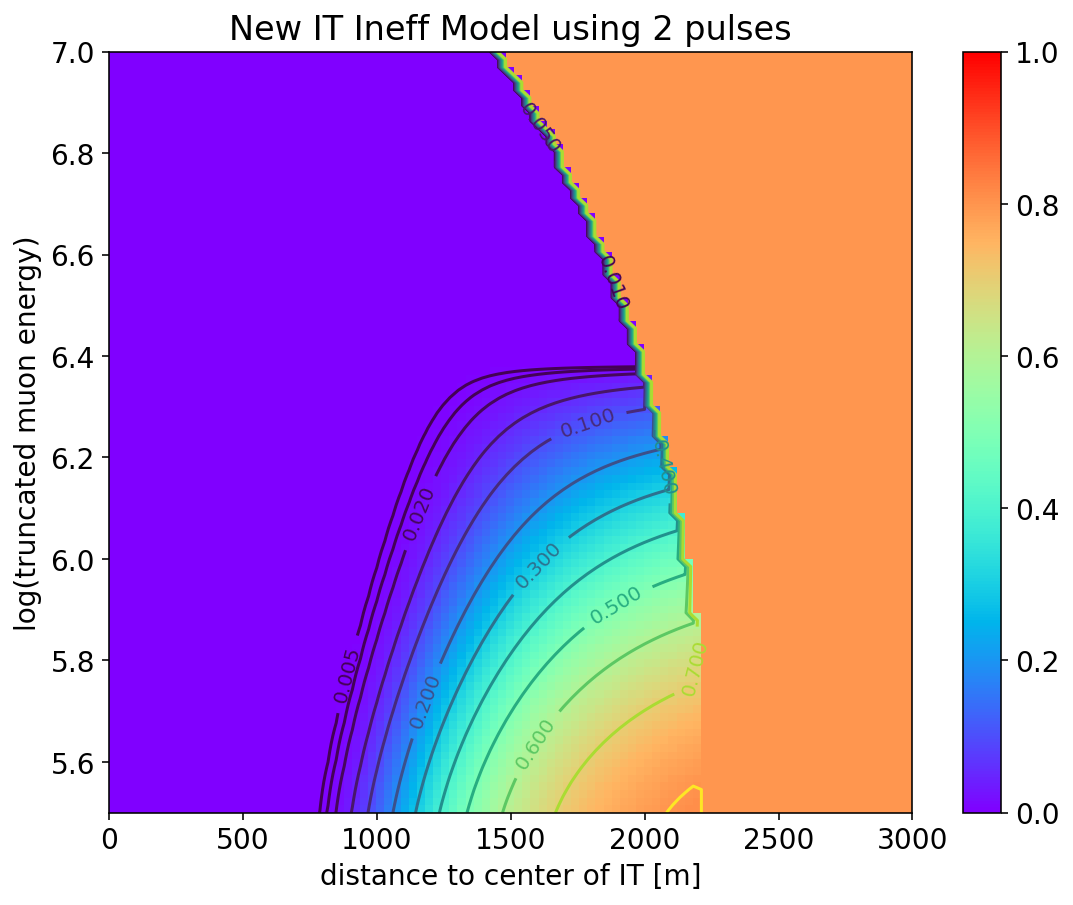

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
# with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
with tables.open_file(data_dir+'data_h5/data_burn_new.h5','r') as f: # 8 years
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564,3550407.43,3186599.156,2706824.349]

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit
    
    ineff_data_burn = ineff_[CUT]

    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)

    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    # IT TW cleaning
#     passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
#     vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    
    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    
    weight_data_burn = np.ones(len(zenith_data_burn))
#     weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [6]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19017
    
    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    ineff_numu = ineff_[CUT]
    
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.MCPrimary_new.cols.energy[:][CUT]
    zenith_truth_numu = f.root.MCPrimary_new.cols.zenith[:][CUT]
    pdg_numu = f.root.MCPrimary_new.cols.pdg_encoding[:][CUT]
    int_type_numu = f.root.I3MCWeightDict.cols.InteractionType[:][CUT]
    
    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    wt_numu = OneWeight/(n_file * NEvents)
    
    runid_numu = f.root.FileNumber.cols.value[:][CUT]
    eventid_numu = f.root.FileNumber.cols.Event[:][CUT]  

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


In [7]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11981.h5','r') as f:
    n_file = 19996
    
    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicaalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon  & CUT_coincident
    
    ineff_nue = ineff_[CUT]

    chi2_red_nue = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_nue = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_nue = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_nue = f.root.Collection.cols.PeakOverMedian[:][CUT]

    zenith_nue = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nue = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_nue = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_nue = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_nue = f.root.QTot.cols.value[:][CUT]
    Qtot_nue = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_nue = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_nue = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_nue = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_nue = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_nue = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_nue = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_nue = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_nue = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_nue = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_nue = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_nue = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_nue = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_nue = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_nue = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_nue = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_nue = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_nue = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_nue = f.root.MCPrimary_new.cols.energy[:][CUT]
    zenith_truth_nue = f.root.MCPrimary_new.cols.zenith[:][CUT]
    pdg_nue = f.root.MCPrimary_new.cols.pdg_encoding[:][CUT]
    int_type_nue = f.root.I3MCWeightDict.cols.InteractionType[:][CUT]

    weight_nue_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_nue_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nue_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    wt_nue = OneWeight/(n_file * NEvents)
    
    runid_nue = f.root.FileNumber.cols.value[:][CUT]
    eventid_nue = f.root.FileNumber.cols.Event[:][CUT]    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [8]:
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11477.h5','r')
f.root.MCPrimary_new.cols.pdg_encoding[:]

array([ 16, -16, -16, ..., -16, -16,  16], dtype=int32)

In [9]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11477.h5','r') as f:
    n_file = 19914
    
    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    ineff_nutau = ineff_[CUT]

    chi2_red_nutau = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_nutau = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_nutau = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_nutau = f.root.Collection.cols.PeakOverMedian[:][CUT]

    zenith_nutau = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nutau = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_nutau = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_nutau = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_nutau = f.root.QTot.cols.value[:][CUT]
    Qtot_nutau = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_nutau = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_nutau = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_nutau = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_nutau = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_nutau = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_nutau = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_nutau = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_nutau = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_nutau = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_nutau = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_nutau = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_nutau = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_nutau = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_nutau = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_nutau = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_nutau = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_nutau = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_nutau = f.root.MCPrimary_new.cols.energy[:][CUT]
    zenith_truth_nutau = f.root.MCPrimary_new.cols.zenith[:][CUT]
    pdg_nutau = f.root.MCPrimary_new.cols.pdg_encoding[:][CUT]
    int_type_nutau = f.root.I3MCWeightDict.cols.InteractionType[:][CUT]
    
    ### astrophysical ### 
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nutau_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    wt_nutau = OneWeight/(n_file * NEvents)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [46]:
stoch_threshold = 2.5
ineff_threshold = 0.01

# data

In [85]:
import json
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_data_burn_signal.json', 'r') as f:
    data_burn = json.load(f)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [51]:
data_burn

{'recoDepositedEnergy': [3302968.8227588385,
  2328115.0295271273,
  1185990.761828877],
 'recoMorphology': [1, 1, 1],
 'recoZenith': [1.2060162740835079, 0.843734001581343, 0.7029334306891621],
 'recoLength': [nan, nan, nan],
 'muonBackground': [0.4509065520774264,
  0.584672773148068,
  0.11456999122081742]}

# nugen

In [77]:
cut_signal_numu = (np.log10(chi2_red_new_numu)>stoch_threshold)&(ineff_numu<ineff_threshold)
cut_signal_nue = (np.log10(chi2_red_new_nue)>stoch_threshold)&(ineff_nue<ineff_threshold)
cut_signal_nutau = (np.log10(chi2_red_new_nutau)>stoch_threshold)&(ineff_nutau<ineff_threshold)

In [78]:
output_dic = {}
output_dic['pionFlux'] = np.concatenate((weight_numu_conv[cut_signal_numu]/2, # assume equal contributions from pion and kaon
                                         weight_nue_conv[cut_signal_nue]/2,
                                         [0]*np.sum(cut_signal_nutau),
#                                          [np.nan]*len(data_burn['muonBackground']),
                                        )).tolist()
output_dic['kaonFlux'] = np.concatenate((weight_numu_conv[cut_signal_numu]/2,
                                         weight_nue_conv[cut_signal_nue]/2,
                                         [0]*np.sum(cut_signal_nutau),
#                                          [np.nan]*len(data_burn['muonBackground']),
                                        )).tolist()
output_dic['convFlux'] = np.concatenate((weight_numu_conv[cut_signal_numu],
                                         weight_nue_conv[cut_signal_nue],
                                         [0]*np.sum(cut_signal_nutau),
#                                          [np.nan]*len(data_burn['muonBackground']),
                                        )).tolist()
output_dic['promptFlux'] = np.concatenate((weight_numu_prompt[cut_signal_numu],
                                           weight_nue_prompt[cut_signal_nue],
                                           [0]*np.sum(cut_signal_nutau),
#                                            [np.nan]*len(data_burn['muonBackground']),
                                          )).tolist()
# output_dic['conventionalSelfVetoCorrection'] = np.concatenate(([np.nan]*np.sum(cut_signal_numu),
#                                                                [np.nan]*np.sum(cut_signal_nue),
#                                                                [np.nan]*np.sum(cut_signal_nutau),
#                                                               )).tolist()
# output_dic['promptSelfVetoCorrection'] = np.concatenate(([np.nan]*np.sum(cut_signal_numu),
#                                                          [np.nan]*np.sum(cut_signal_nue),
#                                                          [np.nan]*np.sum(cut_signal_nutau),
#                                                         )).tolist()
# output_dic['muonBackground'] = np.concatenate(([np.nan]*np.sum(cut_signal_numu),
#                                                        [np.nan]*np.sum(cut_signal_nue),
#                                                        [np.nan]*np.sum(cut_signal_nutau),
#                                                        data_burn['muonBackground'],
#                                                       )).tolist()

with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_flux.json', 'w') as fp:
    json.dump(output_dic, fp)

In [79]:
len(output_dic['pionFlux'])

401

In [80]:
output_dic = {}
output_dic['recoDepositedEnergy'] = np.concatenate((truncated_muon_e_numu[cut_signal_numu],
                                                    truncated_muon_e_nue[cut_signal_nue],
                                                    truncated_muon_e_nutau[cut_signal_nutau],
#                                                     data_burn['recoDepositedEnergy'],
                                                   )).tolist()
output_dic['recoZenith'] = np.concatenate((zenith_numu[cut_signal_numu],
                                           zenith_nue[cut_signal_nue],
                                           zenith_nutau[cut_signal_nutau],
#                                            data_burn['recoZenith'],
                                          )).tolist()
output_dic['recoLength'] = np.concatenate(([np.nan]*np.sum(cut_signal_numu),
                                           [np.nan]*np.sum(cut_signal_nue),
                                           [np.nan]*np.sum(cut_signal_nutau),
#                                            data_burn['recoLength'],
                                          )).tolist()
output_dic['recoMorphology'] = np.concatenate(([1]*np.sum(cut_signal_numu),
                                               [1]*np.sum(cut_signal_nue),
                                               [1]*np.sum(cut_signal_nutau),
#                                                data_burn['recoMorphology'],
                                              )).tolist()

with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_observable.json', 'w') as fp:
    json.dump(output_dic, fp)

In [81]:
len(output_dic['recoDepositedEnergy'])

401

In [82]:
output_dic = {}
output_dic['primaryType'] = np.concatenate((pdg_numu[cut_signal_numu],
                                            pdg_nue[cut_signal_nue],
                                            pdg_nutau[cut_signal_nutau],
#                                             [np.nan]*len(data_burn['muonBackground']),
                                           )).tolist()
output_dic['primaryZenith'] = np.concatenate((zenith_truth_numu[cut_signal_numu],
                                              zenith_truth_nue[cut_signal_nue],
                                              zenith_truth_nutau[cut_signal_nutau],
#                                               [np.nan]*len(data_burn['muonBackground']),
                                             )).tolist()
output_dic['primaryEnergy'] = np.concatenate((prim_e_numu[cut_signal_numu],
                                              prim_e_nue[cut_signal_nue],
                                              prim_e_nutau[cut_signal_nutau],
#                                               [np.nan]*len(data_burn['muonBackground']),
                                             )).tolist()
# OneWeight/(n_file * NEvents)
output_dic['weightOverFluxOverLivetime'] = np.concatenate((wt_numu[cut_signal_numu],
                                                           wt_nue[cut_signal_nue],
                                                           wt_nutau[cut_signal_nutau],
#                                                            [np.nan]*len(data_burn['muonBackground']),
                                                          )).tolist()
output_dic['interactionType'] = np.concatenate((int_type_numu[cut_signal_numu],
                                                int_type_nue[cut_signal_nue],
                                                int_type_nutau[cut_signal_nutau],
#                                                 [np.nan]*len(data_burn['muonBackground']),
                                               )).tolist()

with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_truth.json', 'w') as fp:
    json.dump(output_dic, fp)

In [83]:
len(output_dic['primaryType'])

401

In [74]:
# total signal before cut
np.sum(weight_numu_astro) + \
np.sum(weight_numu_conv) + \
np.sum(weight_numu_prompt) + \
np.sum(weight_nue_astro) + \
np.sum(weight_nue_conv) + \
np.sum(weight_nue_prompt) + \
np.sum(weight_nutau_astro)

6.714892263303963

In [75]:
# total neutrino in signal region
np.sum(weight_numu_astro[cut_signal_numu]) + \
np.sum(weight_numu_conv[cut_signal_numu]) + \
np.sum(weight_numu_prompt[cut_signal_numu]) + \
np.sum(weight_nue_astro[cut_signal_nue]) + \
np.sum(weight_nue_conv[cut_signal_nue]) + \
np.sum(weight_nue_prompt[cut_signal_nue]) + \
np.sum(weight_nutau_astro[cut_signal_nutau])

0.4294114737228161

# try myown events

In [30]:
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_data_burn_signal.json','r') as f:
    data=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_flux.json','r') as f:
    mc_flux=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_observable.json','r') as f:
    mc_observable=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/my_mc_truth.json','r') as f:
    mc_truth=json.load(f)

In [31]:
# livetime = 8 * 86400 * 365
# plt.hist(mc_observable['recoDepositedEnergy'],weights=1e-18*params['astro_norm']/6.0 * livetime *(np.array(mc_truth['primaryEnergy'])/1e5)**(-params['astro_gamma'])*mc_truth['weightOverFluxOverLivetime'],bins=ebins)
# plt.loglog()

In [32]:
parameter_names = [
    "cr_delta_gamma",
    "nunubar_ratio",
    "anisotropy_scale",
    "astro_gamma",
    "astro_norm",
    "conv_norm",
    "epsilon_dom",
    "epsilon_head_on",
    "muon_norm",
    "kpi_ratio",
    "prompt_norm",
]
parameter_values = [
        # no detector effect
#         -0.05309302,
#         0.99815326,
#         1,
#         2.,
#         6.36488608,
#         1.00621679,
#         0.99,
#         0,
#         1.18706341,
#         1.00013744,
#         0.5,
    
        # ignore all flux systematics
        0,
        1,
        1,
        2.,
        6.36488608,
        1.00621679,
        0.99,
        0,
        0,
        1,
        0,
    ]

params=dict(zip(parameter_names,parameter_values))

In [33]:
# myown 
livetime = 86400 * 365 * 8
ebins = np.logspace(5.5, 8, 30)
bin_centers = 10.0 ** (0.5 * (np.log10(ebins[:-1]) + np.log10(ebins[1:])))

cm = plt.get_cmap("inferno")
color_scale = [cm(x) for x in [0.2, 0.55, 0.75, 0.9]]

# flux: muon, astro, atm
# weight_muon = livetime*params['muon_norm']*np.array(mc_flux['muonWeightOverLivetime']) # VERIFIED

nunubar = np.ones_like(np.array(mc_flux['pionFlux']))
nunubar[np.array(mc_truth['primaryType'])>0] = params['nunubar_ratio']
nunubar[np.array(mc_truth['primaryType'])<0] = 2-params['nunubar_ratio']

# tilt_conv = (np.array(mc_truth['primaryEnergy'])/2020.0)**(-params['cr_delta_gamma'])
weight_pion = np.array(mc_flux['pionFlux'])#*np.array(mc_flux['conventionalSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']
weight_kaon = np.array(mc_flux['kaonFlux'])#*np.array(mc_flux['conventionalSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']
# weight_conv = livetime*params['conv_norm']*tilt_conv*nunubar * (weight_pion + params['kpi_ratio']*weight_kaon)
weight_conv = np.array(mc_flux['convFlux'])

# tilt_prompt = (np.array(mc_truth['primaryEnergy'])/7887.0)**(-params['cr_delta_gamma'])
weight_prompt = np.array(mc_flux['promptFlux'])#*np.array(mc_flux['promptSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']  # VERIFIED
# weight_prompt = livetime*params['prompt_norm']*tilt_prompt*nunubar * weight_prompt

weight_astro = 1e-18*params['astro_norm']/6.0 * livetime *(np.array(mc_truth['primaryEnergy'])/1e5)**(-params['astro_gamma'])* np.array(mc_truth['weightOverFluxOverLivetime']) # VERIFIED 

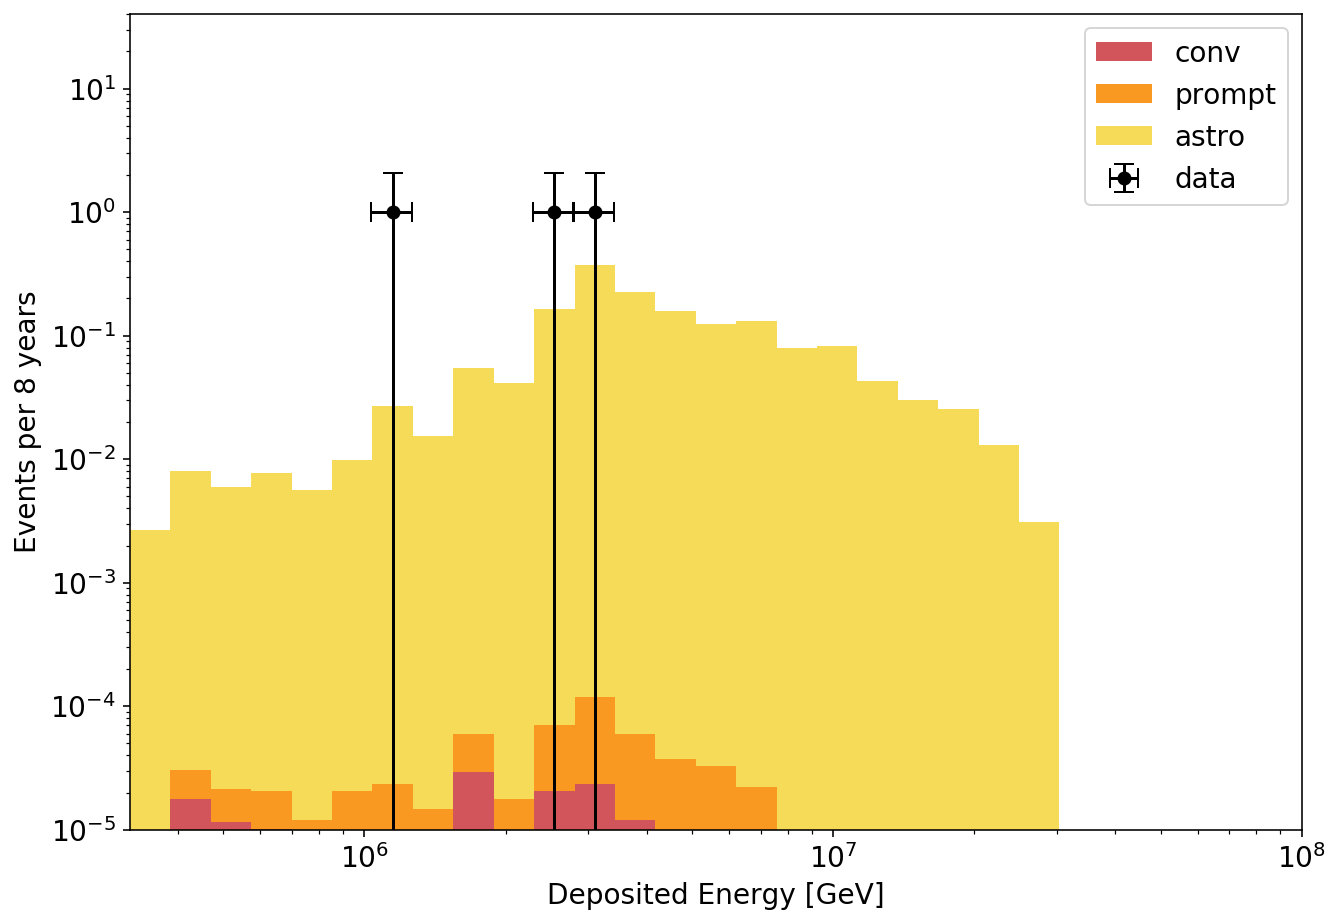

In [34]:
# myown
plt.figure(figsize=(7*1.5,5*1.5))
h_data,b_ = np.histogram(data['recoDepositedEnergy'],bins=ebins)

plt.errorbar(bin_centers,h_data,fmt='o',yerr=8*386*86400/livetime*np.sqrt(h_data),xerr=np.diff(ebins)/2,color='black',capsize=5,label='data') # VERIFIED

h,b,_=plt.hist([mc_observable['recoDepositedEnergy']]*3,
            weights=[
                     weight_conv,
                     weight_prompt,
                     weight_astro,
                     ],
            label=[
                   'conv',
                   'prompt',
                   'astro',
                  ],
            color=[
                   color_scale[1],
                   color_scale[2],
                   color_scale[3]],
            bins=ebins,
            alpha=0.9,stacked=True,)

plt.xlim(10**5.5,1e8)
plt.ylim(1.0e-5, 4.0e1)
plt.legend()
plt.xlabel("Deposited Energy [GeV]")
plt.ylabel("Events per 8 years")
plt.loglog()
plt.show()

# check if 2D binning agrees with HESE data release code

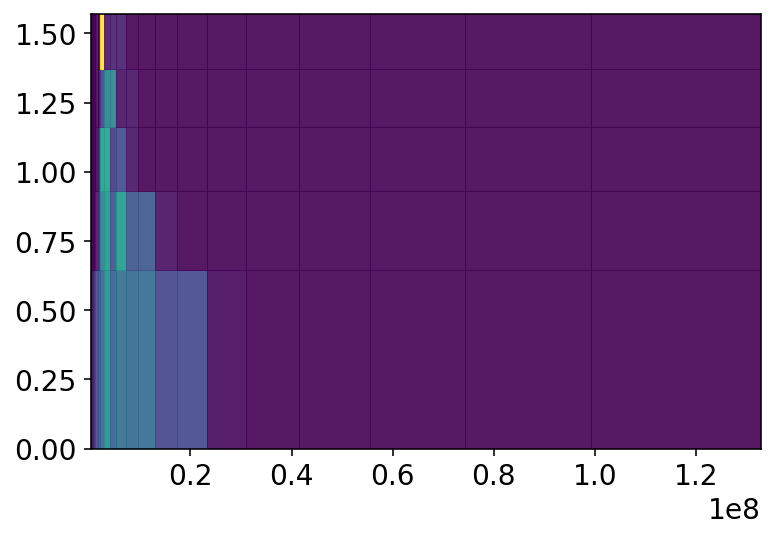

In [739]:
ebins = np.logspace(np.log10(300000.0), np.log10(132776511.70878801), 22)
zbins = np.arccos(np.linspace(0, 1, 5 + 1))[::-1]
h_mc,_,_,_=plt.hist2d(mc_observable['recoDepositedEnergy']*3,mc_observable['recoZenith']*3,
            weights=np.concatenate((
                     weight_conv,
                     weight_prompt,
                     weight_astro,
            )),

            bins=[ebins,zbins],
            alpha=0.9)

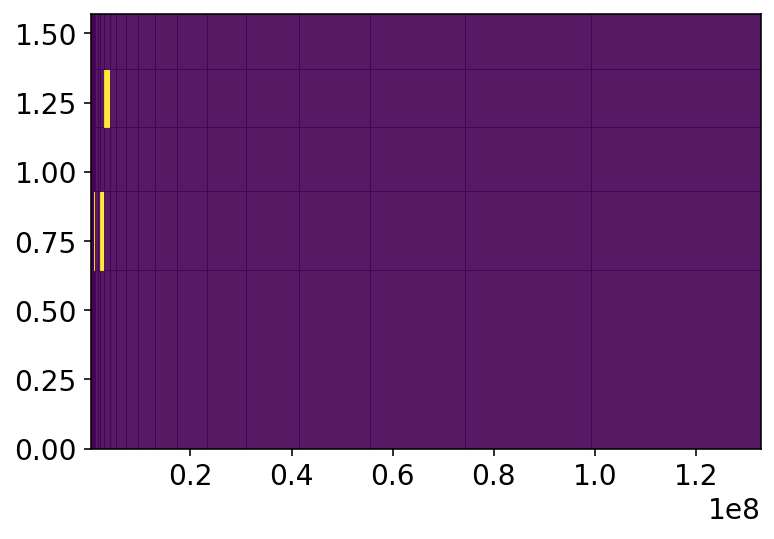

In [741]:
ebins = np.logspace(np.log10(300000.0), np.log10(132776511.70878801), 22)
zbins = np.arccos(np.linspace(0, 1, 5 + 1))[::-1]
h_data,_,_,_=plt.hist2d(data['recoDepositedEnergy'],data['recoZenith'],
#             weights=np.concatenate((
#                      weight_conv,
#                      weight_prompt,
#                      weight_astro,
#             )),

            bins=[ebins,zbins],
            alpha=0.9)

In [756]:
print(h_data.T)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [755]:
print(h_mc.T[h_data.astype(bool).T])

[0.00199772 0.07036589 0.07101486]


In [766]:
def sel(e,z,w):
    sels = (e>ebins[3])&(e<ebins[4])&(z>zbins[1])&(z<zbins[2])
    return w[sels]

In [767]:
np.sum(sel(truncated_muon_e_numu,zenith_numu,weight_numu_astro))

0.09933692219005488

#  reproduce HESE energy distribution

In [585]:
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/HESE_data.json','r') as f:
    data=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/HESE_mc_flux.json','r') as f:
    mc_flux=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/HESE_mc_observable.json','r') as f:
    mc_observable=json.load(f)
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/data/HESE_mc_truth.json','r') as f:
    mc_truth=json.load(f)

In [586]:
print(data.keys())
print(mc_flux.keys())
print(mc_observable.keys())
print(mc_truth.keys())

dict_keys(['recoDepositedEnergy', 'recoMorphology', 'recoZenith', 'recoLength'])
dict_keys(['pionFlux', 'kaonFlux', 'promptFlux', 'conventionalSelfVetoCorrection', 'promptSelfVetoCorrection', 'muonWeightOverLivetime'])
dict_keys(['recoDepositedEnergy', 'recoLength', 'recoZenith', 'recoMorphology'])
dict_keys(['primaryType', 'primaryZenith', 'primaryEnergy', 'weightOverFluxOverLivetime', 'interactionType'])


In [587]:
parameter_names = [
    "cr_delta_gamma",
    "nunubar_ratio",
    "anisotropy_scale",
    "astro_gamma",
    "astro_norm",
    "conv_norm",
    "epsilon_dom",
    "epsilon_head_on",
    "muon_norm",
    "kpi_ratio",
    "prompt_norm",
]
parameter_values = [
        # no detector effect
        -0.05309302,
        0.99815326,
        1,
        2.87375956,
        6.36488608,
        1.00621679,
        0.99,
        0,
        1.18706341,
        1.00013744,
        0.5,
    ]
#        # no detector effect
#         -0.05309302,
#         0.99815326,
#         1,
#         2.87375956,
#         6.36488608,
#         1.00621679,
#         1,
#         0,
#         1.18706341,
#         1.00013744,
#         0.0,
#     ]

params=dict(zip(parameter_names,parameter_values))

In [588]:
params

{'cr_delta_gamma': -0.05309302,
 'nunubar_ratio': 0.99815326,
 'anisotropy_scale': 1,
 'astro_gamma': 2.87375956,
 'astro_norm': 6.36488608,
 'conv_norm': 1.00621679,
 'epsilon_dom': 0.99,
 'epsilon_head_on': 0,
 'muon_norm': 1.18706341,
 'kpi_ratio': 1.00013744,
 'prompt_norm': 0.5}

In [589]:
livetime = 227708167.68
ebins = np.logspace(3.8901512503836435, 7.109151250383643, 30)
bin_centers = 10.0 ** (0.5 * (np.log10(ebins[:-1]) + np.log10(ebins[1:])))

cm = plt.get_cmap("inferno")
color_scale = [cm(x) for x in [0.2, 0.55, 0.75, 0.9]]

# flux: muon, astro, atm
weight_muon = livetime*params['muon_norm']*np.array(mc_flux['muonWeightOverLivetime']) # VERIFIED

nunubar = np.ones_like(np.array(mc_flux['pionFlux']))
nunubar[np.array(mc_truth['primaryType'])>0] = params['nunubar_ratio']
nunubar[np.array(mc_truth['primaryType'])<0] = 2-params['nunubar_ratio']

tilt_conv = (np.array(mc_truth['primaryEnergy'])/2020.0)**(-params['cr_delta_gamma'])
weight_pion = np.array(mc_flux['pionFlux'])*np.array(mc_flux['conventionalSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']
weight_kaon = np.array(mc_flux['kaonFlux'])*np.array(mc_flux['conventionalSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']
weight_conv = livetime*params['conv_norm']*tilt_conv*nunubar * (weight_pion + params['kpi_ratio']*weight_kaon)

tilt_prompt = (np.array(mc_truth['primaryEnergy'])/7887.0)**(-params['cr_delta_gamma'])
weight_prompt = np.array(mc_flux['promptFlux'])*np.array(mc_flux['promptSelfVetoCorrection'])* mc_truth['weightOverFluxOverLivetime']  # VERIFIED
weight_prompt = livetime*params['prompt_norm']*tilt_prompt*nunubar * weight_prompt

weight_astro = 1e-18*params['astro_norm']/6.0 * livetime *(np.array(mc_truth['primaryEnergy'])/1e5)**(-params['astro_gamma'])* np.array(mc_truth['weightOverFluxOverLivetime']) # VERIFIED 

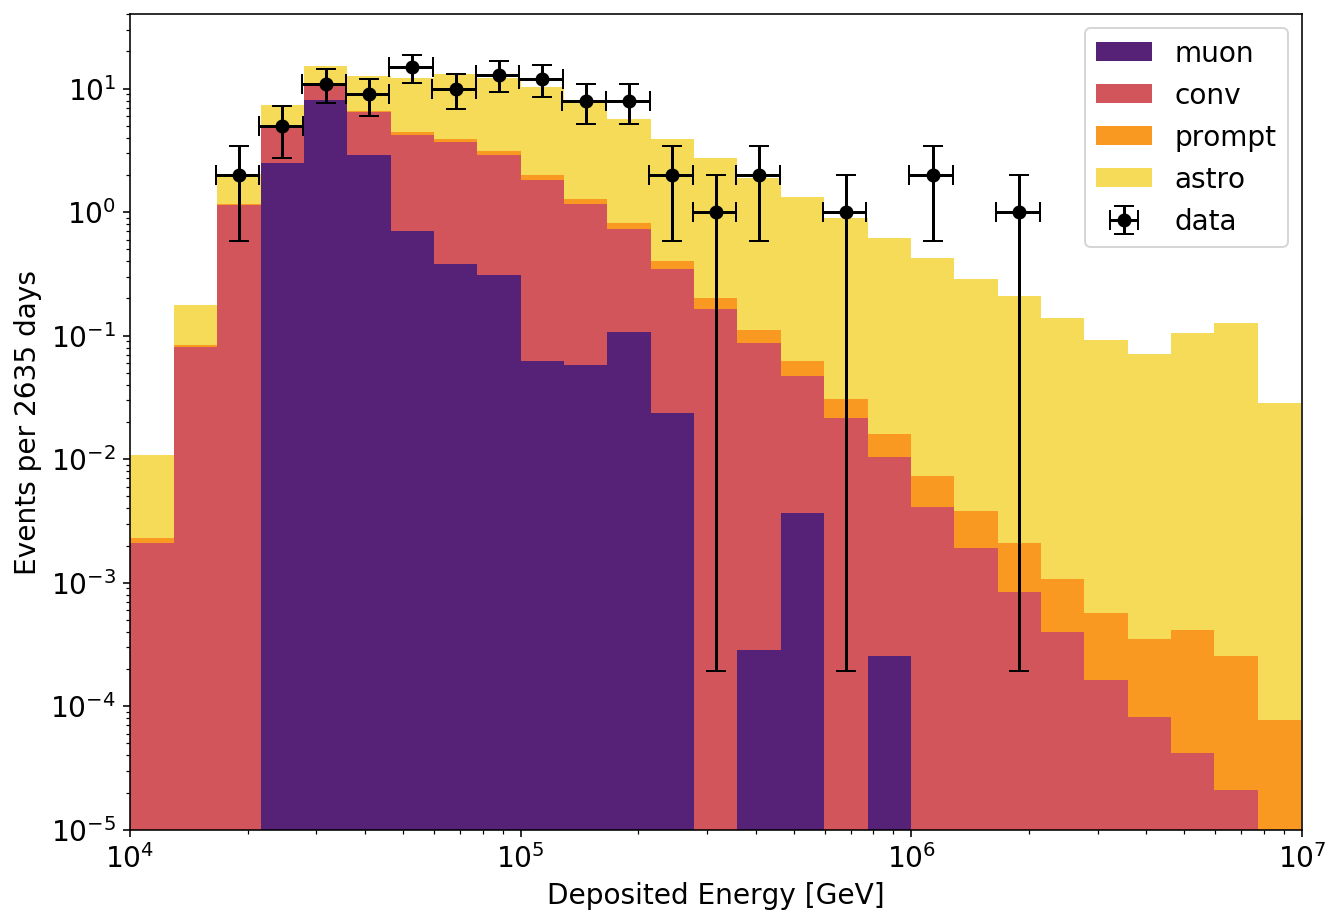

In [590]:
plt.figure(figsize=(7*1.5,5*1.5))
h,b_ = np.histogram(data['recoDepositedEnergy'],bins=ebins)

plt.errorbar(bin_centers,h,fmt='o',yerr=2635*86400/livetime*np.sqrt(h),xerr=np.diff(ebins)/2,color='black',capsize=5,label='data') # VERIFIED

h,b,_=plt.hist([mc_observable['recoDepositedEnergy']]*4,
            weights=[weight_muon,
                     weight_conv,
                     weight_prompt,
                     weight_astro,
                     ],
            label=['muon',
                   'conv',
                   'prompt',
                   'astro',
                  ],
            color=[color_scale[0],
                   color_scale[1],
                   color_scale[2],
                   color_scale[3]],
            bins=ebins,
            alpha=0.9,stacked=True,)

plt.xlim(1e4,1e7)
plt.ylim(1.0e-5, 4.0e1)
plt.legend()
plt.xlabel("Deposited Energy [GeV]")
plt.ylabel("Events per 2635 days")
plt.loglog()
plt.show()

In [591]:
component_order = [
    ("muon_norm", "Atmo. Muons"), # Verified with hand calculation
    ("conv_norm", "Atmo. Conv."),
    ("prompt_norm", "Atmo. Prompt"),
    ("astro_norm", "Astro."),
]

for i,(j,k) in zip(h,component_order):
    print(k+': ', i)
# all values agree with HESE_fit.py except the boundary bins. Maybe detector sys. calculation with spline introduced variations??

Atmo. Muons:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.50408464e+00 8.02451638e+00 2.90967239e+00 7.02205308e-01
 3.80015484e-01 3.11170988e-01 6.23695029e-02 5.80941491e-02
 1.07559521e-01 2.36720941e-02 0.00000000e+00 2.87160184e-04
 3.67272248e-03 0.00000000e+00 2.53851505e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Atmo. Conv.:  [5.13527441e-03 2.10054259e-03 8.10050823e-02 1.13600513e+00
 4.87050025e+00 1.10075708e+01 6.51037327e+00 4.25377295e+00
 3.72336208e+00 2.90704512e+00 1.82777474e+00 1.15739179e+00
 7.25308294e-01 3.45255154e-01 1.63026727e-01 8.67805920e-02
 4.71567332e-02 2.17426166e-02 1.04866107e-02 4.06271161e-03
 1.89884003e-03 8.45779340e-04 4.01833322e-04 1.63674715e-04
 8.24571348e-05 4.17071641e-05 2.08338291e-05 4.15727952e-06
 6.31181535e-07]
Atmo. Prompt:  [5.41695350e-03 2.31139137e-03 8.36586219e-02 1.16012440e+00
 4.93658